In [10]:
!cp -r ./drive/MyDrive/ml_assignment2/cnn_dataset /content/dataset
dataset_path = './dataset'

In [1]:
!pip install torchsummary
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve
from torchsummary import summary

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='./dataset', transform=transform)

train_dataset_fraction = 0.7
val_dataset_fraction = 0.15

train_size = int(train_dataset_fraction * len(dataset))
val_size = int(val_dataset_fraction * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Training Dataset size: {train_size}, Validation Dataset Size: {val_size}, Test Dataset Size: {test_size}")

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

Training Dataset size: 69006, Validation Dataset Size: 14787, Test Dataset Size: 14787


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=512 * 1 * 1,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=36),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [23]:
model = VGG13().to(device)
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,792
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          36,928
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]          73,856
              ReLU-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]         147,584
              ReLU-9          [-1, 128, 14, 14]               0
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         590,080
             ReLU-14            [-1, 25

In [24]:
epochs = 5
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = [], [], [], []

start_time = time.time()
for epoch in range(epochs):
    model.train()
    train_loss, correct_predictions = 0, 0
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        if (batch_index+1)%100==0:
          print(f"Epoch: {epoch+1}/{epochs}, Batch: {batch_index+1}/{len(train_loader)}")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        train_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

    train_loss_list.append(train_loss / len(train_loader.dataset))
    train_accuracy_list.append(correct_predictions / len(train_loader.dataset))

    model.eval()
    val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            curr_batch_scaled_loss = loss.item() * inputs.size(0)
            val_loss += curr_batch_scaled_loss

            predicted_labels = outputs.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader.dataset))
    val_accuracy_list.append(correct_predictions / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {train_loss_list[-1]:.4f}, "
          f"Validation Loss: {val_loss_list[-1]:.4f}, "
          f"Training Accuracy: {train_accuracy_list[-1]:.4f}, "
          f"Validation Acc: {val_accuracy_list[-1]:.4f}")

    print(f"{(time.time()-start_time):.4f} seconds has passed:")
end_time = time.time()


print(f"Training took {(end_time-start_time):.4f} seconds:")



Epoch: 1/5, Batch: 100/540
Epoch: 1/5, Batch: 200/540
Epoch: 1/5, Batch: 300/540
Epoch: 1/5, Batch: 400/540
Epoch: 1/5, Batch: 500/540
Epoch 1/5, Training Loss: 3.2043, Validation Loss: 1.9528, Training Accuracy: 0.0807, Validation Acc: 0.3256
68.2805 seconds has passed:
Epoch: 2/5, Batch: 100/540
Epoch: 2/5, Batch: 200/540
Epoch: 2/5, Batch: 300/540
Epoch: 2/5, Batch: 400/540
Epoch: 2/5, Batch: 500/540
Epoch 2/5, Training Loss: 0.7926, Validation Loss: 0.4542, Training Accuracy: 0.7349, Validation Acc: 0.8504
137.1350 seconds has passed:
Epoch: 3/5, Batch: 100/540
Epoch: 3/5, Batch: 200/540
Epoch: 3/5, Batch: 300/540
Epoch: 3/5, Batch: 400/540
Epoch: 3/5, Batch: 500/540
Epoch 3/5, Training Loss: 0.3703, Validation Loss: 0.3626, Training Accuracy: 0.8834, Validation Acc: 0.8878
206.1279 seconds has passed:
Epoch: 4/5, Batch: 100/540
Epoch: 4/5, Batch: 200/540
Epoch: 4/5, Batch: 300/540
Epoch: 4/5, Batch: 400/540
Epoch: 4/5, Batch: 500/540
Epoch 4/5, Training Loss: 0.2995, Validation Lo

In [25]:
torch.save(model.state_dict(), 'vgg_model_gc.pt')

In [26]:
model.eval()
test_loss, correct_predictions = 0, 0
y_actual, y_predicted = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        curr_batch_scaled_loss = loss.item() * inputs.size(0)
        test_loss += curr_batch_scaled_loss

        predicted_labels = outputs.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

        y_actual.extend(labels.cpu().numpy())
        y_predicted.extend(predicted_labels.cpu().numpy())

In [27]:
test_accuracy = correct_predictions / len(test_loader.dataset)
test_loss /= len(test_loader.dataset)
precision, recall, f1, _ = precision_recall_fscore_support(y_actual, y_predicted, average="macro")

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Test Loss: 0.2880, Test Accuracy: 0.9108
Precision: 0.9201, Recall: 0.9099, F1 Score: 0.9056


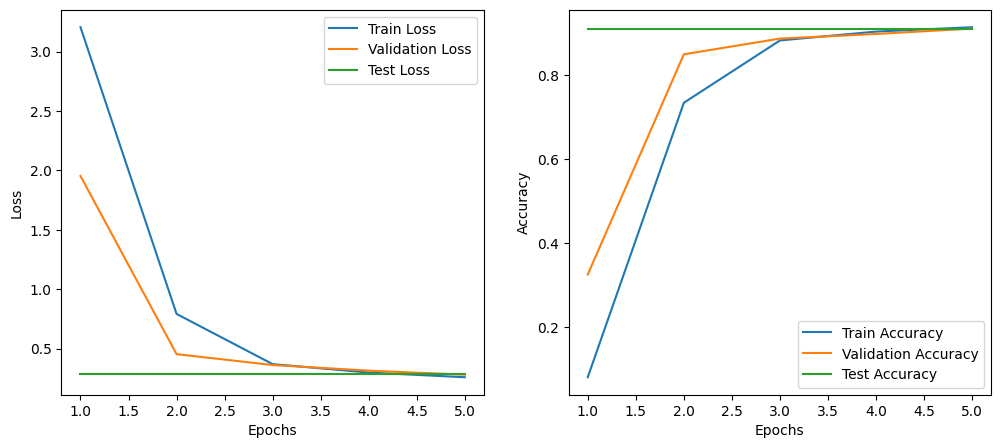

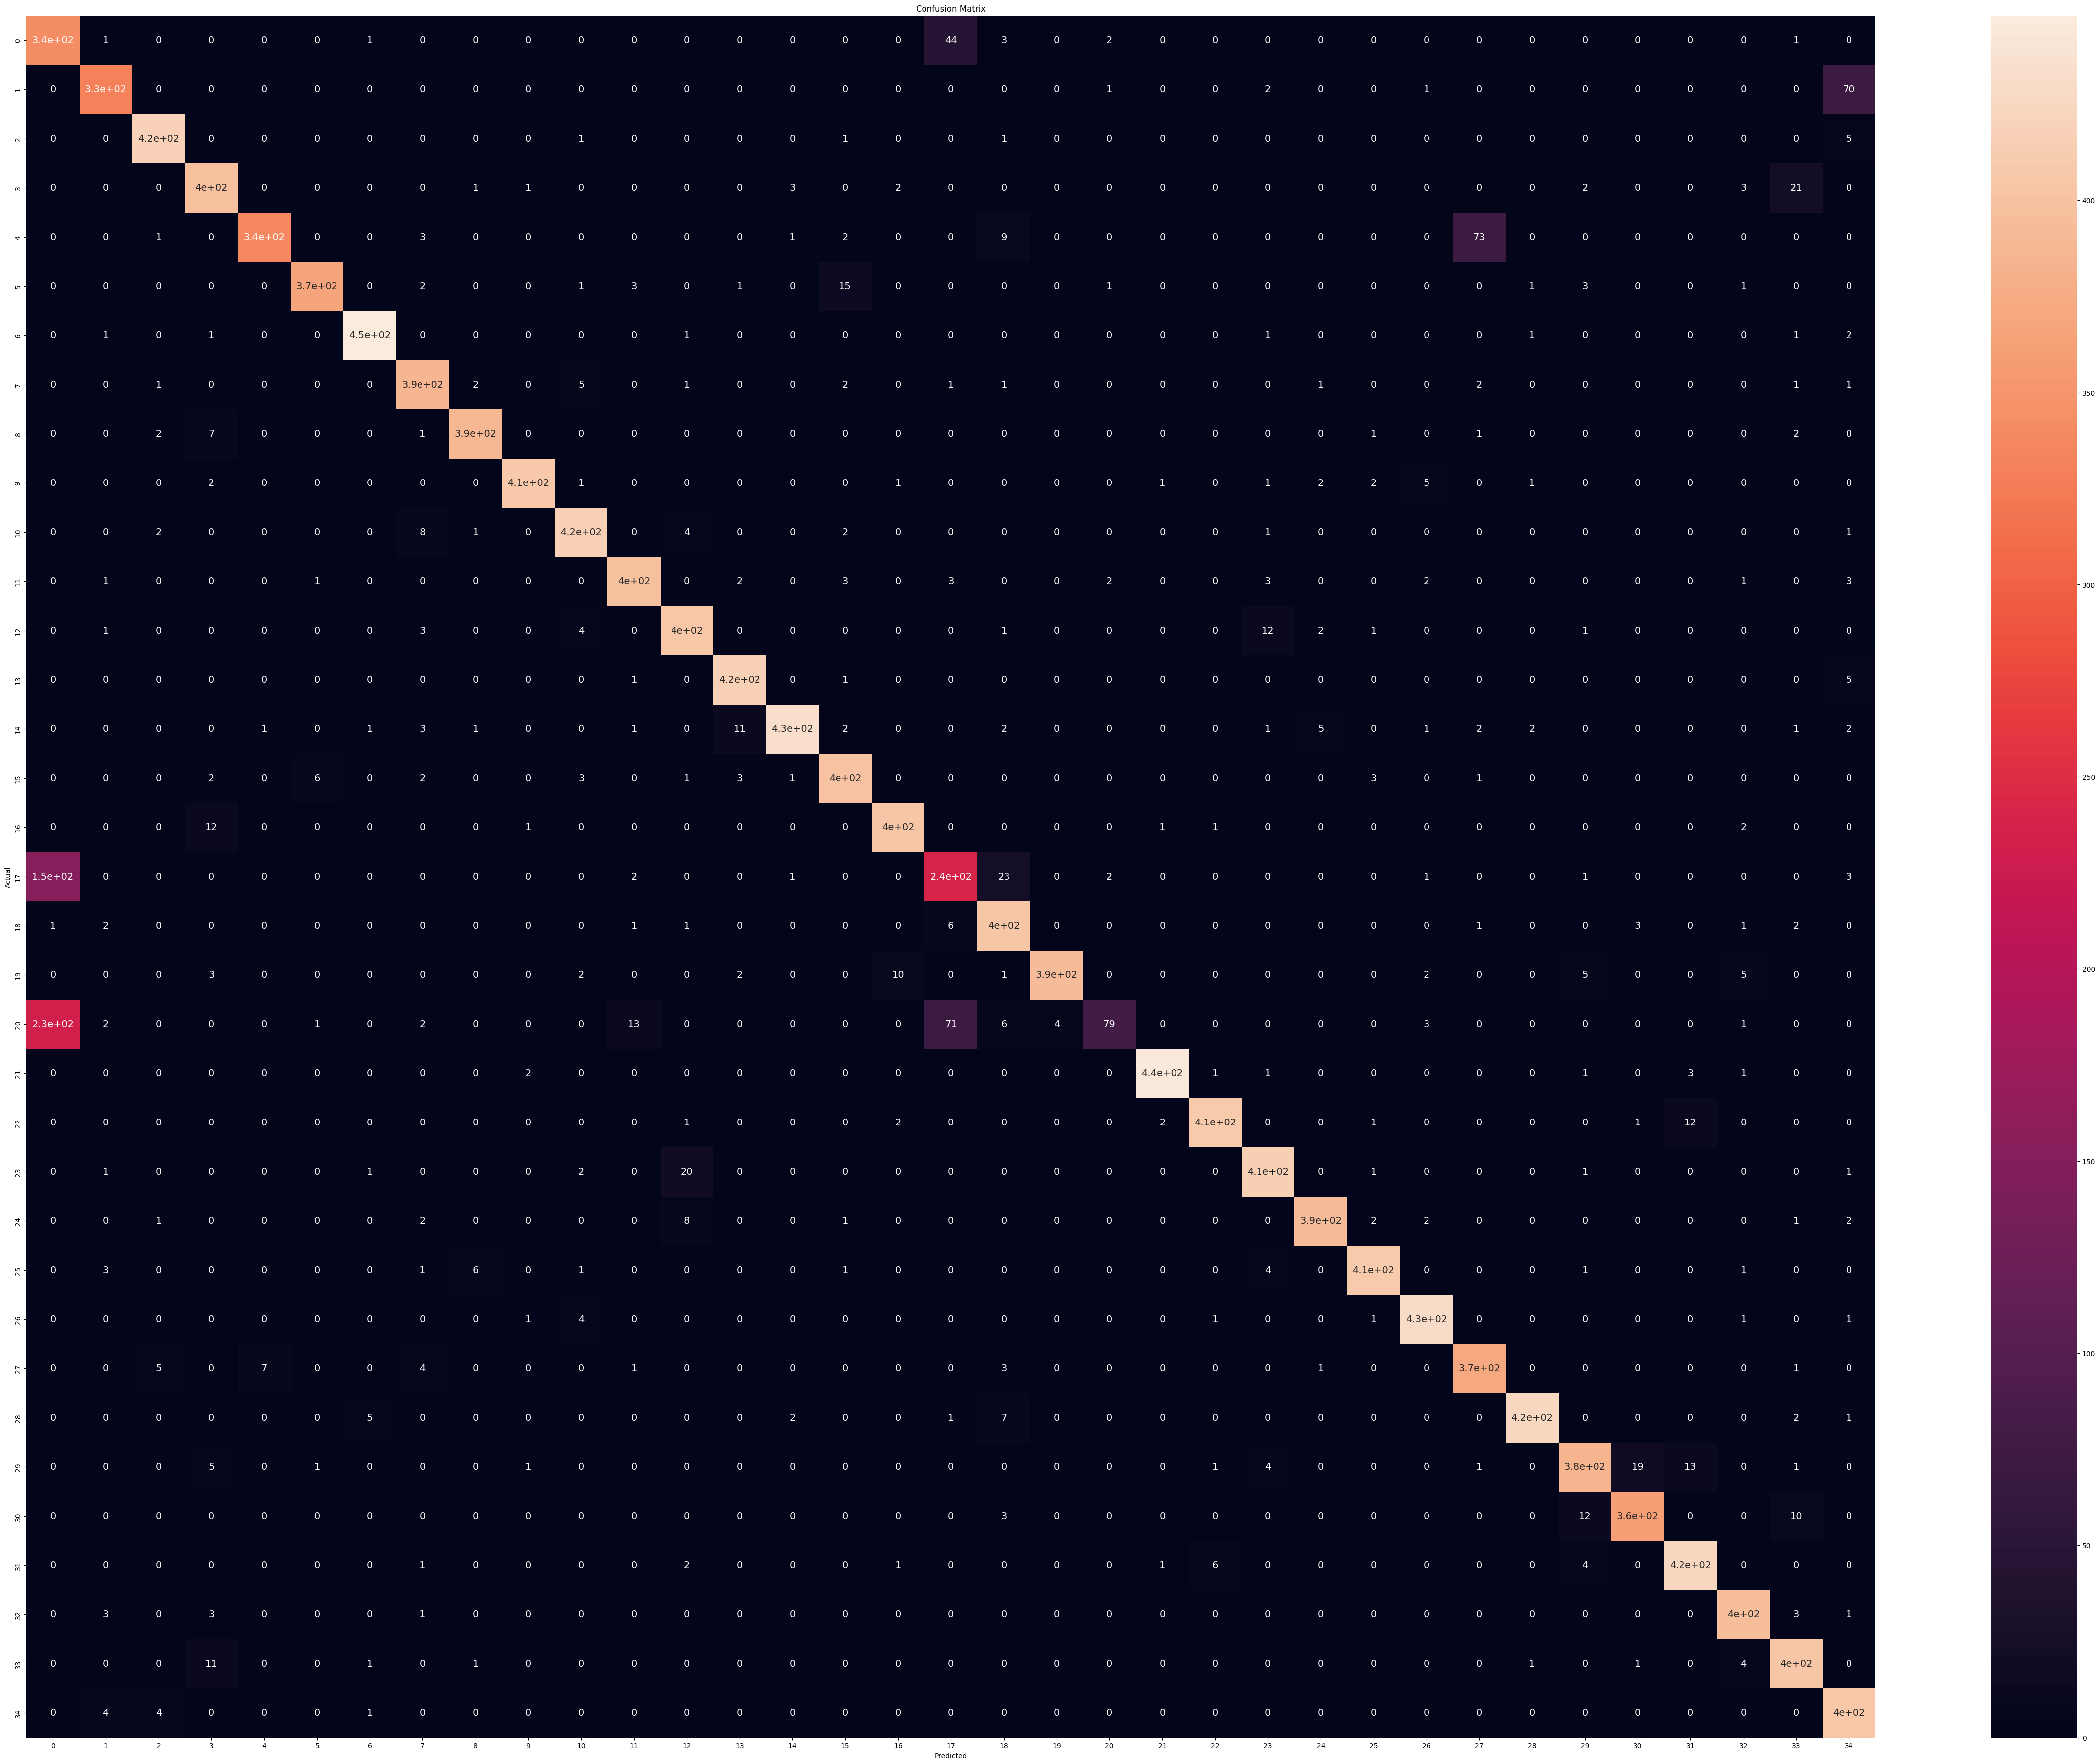

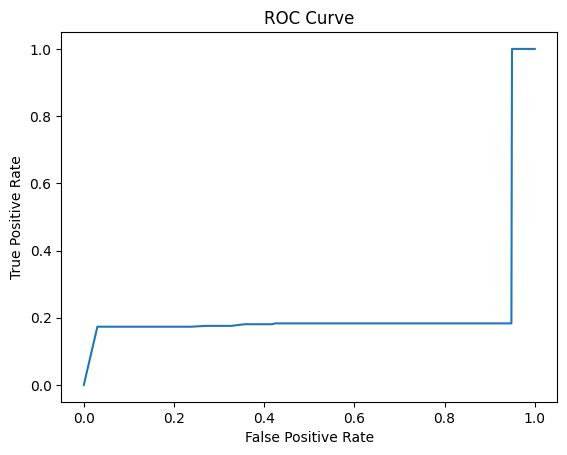

In [28]:
range_epochs = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range_epochs, train_loss_list, label='Train Loss')
plt.plot(range_epochs, val_loss_list, label='Validation Loss')
plt.plot(range_epochs, [test_loss]*epochs, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range_epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(range_epochs, val_accuracy_list, label='Validation Accuracy')
plt.plot(range_epochs, [test_accuracy]*epochs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
plt.figure(figsize=(60, 45))
cm = confusion_matrix(y_actual, y_predicted)
sns.heatmap(cm, annot=True, annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_actual), np.array(y_predicted), pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()